In [280]:
import contextlib
import io

import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns 

from scipy.interpolate import interp1d

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Bidirectional, GRU

In [281]:
def split_dataframe(df, train_size=0.7, val_size=0.2):
    """
    Découpe un DataFrame temporel en trois parties : train, val, test,
    en respectant l'ordre chronologique.

    Args:
        df (pd.DataFrame): Données à découper (indexé ou non par le temps)
        train_size (float): Proportion pour l'ensemble d'entraînement
        val_size (float): Proportion pour la validation

    Returns:
        df_train, df_val, df_test (DataFrames)
    """
    n = len(df)
    train_end = int(n * train_size)
    val_end = int(n * (train_size + val_size))

    df_train = df.iloc[:train_end]
    df_val = df.iloc[train_end:val_end]
    df_test = df.iloc[val_end:]

    print(f"Train size : {len(df_train)}")
    print(f"Val size : {len(df_val)}")
    print(f"Test size : {len(df_test)}")

    return df_train.copy(), df_val.copy(), df_test.copy()

In [282]:
def evaluate_model(y_true, y_pred):
    """
    Calcule et affiche les métriques MAE, RMSE et R² entre les vraies valeurs et les prédictions.

    Args:
        y_true (array-like): Valeurs réelles.
        y_pred (array-like): Valeurs prédites.
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f'MAE: {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'R2 Score: {r2:.4f}')
    
    return {"MAE":mae, "RMSE":rmse, "R2 Score":r2}

In [283]:
def create_dataset(X, y, time_steps=1):  
    Xs, ys = [], []   
    for i in range(len(X) - time_steps):   
        v = X.iloc[i:(i + time_steps)].values 
        Xs.append(v)      
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

    """
This function prepares the input features and target values in the format required for training a recurrent neural network (RNN) or LSTM model for sequential prediction tasks. It creates sequences of input features and their corresponding target values, which can be fed into the model during training.

    - X: This parameter represents the input features, typically a pandas DataFrame containing multiple time-series variables such as temperature, humidity, etc.
    - y: This parameter represents the target values, which are typically the values we want to predict based on the input features.
    - time_steps: This parameter defines the length of each sequence. It determines how many data points from the past will be used to predict the next data point. For example, if time_steps is set to 3, the function will create sequences of three consecutive data points as input features and the next data point as the target value.
    """

In [284]:
def build_and_train_bilstm(X_train, y_train, X_val, y_val, sequence_length, units=100, 
                           activation='tanh', epochs=30, batch_size=32, patience=10):
    """
    Construit, entraîne et évalue un modèle BiLSTM avec early stopping.

    Args:
        X_train (ndarray): Données d'entraînement (3D).
        y_train (ndarray): Cibles d'entraînement.
        X_val (ndarray): Données de validation (3D).
        y_val (ndarray): Cibles de validation.
        sequence_length (int): Longueur des séquences en entrée.
        units (int): Nombre de neurones dans la couche LSTM.
        activation (str): Fonction d'activation de la couche LSTM.
        epochs (int): Nombre d’époques d’entraînement.
        batch_size (int): Taille de lot pour l’entraînement.
        patience (int): Patience pour l’early stopping.

    Returns:
        model: Le modèle entraîné.
        history: L'historique d'entraînement.
        val_loss: La perte de validation finale.
    """
    model = Sequential()
    model.add(Bidirectional(LSTM(units, activation=activation, input_shape=(sequence_length, X_train.shape[2]))))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=1
    )

    val_loss = model.evaluate(X_val, y_val, verbose=0)
    display(f'Validation Loss: {val_loss}')

    return model, history, val_loss


In [285]:
def load_data_drias(path_fichier_excel):
    """
    Charge un fichier Excel DRIAS avec une colonne 'Date' au format '%d/%m/%Y',
    et retourne un DataFrame avec la date en index.

    Args:
        path_fichier_excel (str): Chemin vers le fichier Excel.

    Returns:
        pd.DataFrame: Données DRIAS avec l'index daté.
    """
    df = pd.read_excel(path_fichier_excel)
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
    df.set_index('Date', inplace=True)
    display(df)
    
    return df

In [286]:
def predict_and_inverse_transform(model, X, y, target_transformer):
    """
    Effectue la prédiction avec le modèle donné et applique l'inverse de la transformation 
    sur les prédictions et les vraies valeurs cibles.

    Args:
        model: Modèle entraîné (ex. BiLSTM).
        X_val: Données d'entrée de validation.
        y_val: Vraies valeurs cibles de validation.
        target_transformer: Transformateur utilisé pour normaliser les cibles (ex. MinMaxScaler).

    Returns:
        Tuple (y_pred_original_scale, y_true_original_scale)
    """
    # Prédiction
    y_pred = model.predict(X)

    # Inversion de la transformation des prédictions
    y_pred_inv = target_transformer.inverse_transform(y_pred)

    # Reshape puis inversion de la transformation des vraies valeurs
    y = y.reshape(-1, 1)
    y_val_inv = target_transformer.inverse_transform(y)

    return y_pred_inv, y_val_inv

In [287]:
def convertir_q_en_rh(q_kgkg, temperature_C, pression_hPa=1013.25):
    """
    Convertit une série d'humidité spécifique (kg/kg) et de température (°C)
    en humidité relative (%) en supposant une pression constante.

    Paramètres :
        q_kgkg : pd.Series ou np.array d'humidité spécifique (kg/kg)
        temperature_C : pd.Series ou np.array de température (°C)
        pression_hPa : pression atmosphérique en hPa (par défaut = 1013.25)

    Retour :
        pd.Series ou np.array d'humidité relative (%) — même type que l'entrée
    """
    q = np.asarray(q_kgkg)
    T = np.asarray(temperature_C)

    # Pression partielle de vapeur d'eau (e) [hPa]
    e = (q * pression_hPa) / (0.622 + 0.378 * q)

    # Pression de vapeur saturante (e_s) [hPa] — formule de Tetens
    e_s = 6.112 * np.exp((17.67 * T) / (T + 243.5))

    # Humidité relative RH [%]
    RH = 100 * e / e_s
    RH = np.clip(RH, 0, 100)

    # Renvoyer dans le même format que l'entrée
    if isinstance(q_kgkg, pd.Series):
        return pd.Series(RH, index=q_kgkg.index, name='RH_%')
    else:
        return RH

In [288]:
def extract_24h_values(group):
    if len(group) == 24:
        return group.values
    else:
        print(group)

##### **Dataset DRIAS RCP**

In [289]:
data_rcp_2_6 = load_data_drias('Drias/CNRM-CERFACS-CNRM-CM5_CNRM-ALADIN63_rcp2.6_METEO-FRANCE_ADAMONT-France_SAFRAN_day_2006_2100.xlsx')

,Latitude,Longitude,tasminAdjust,tasmaxAdjust,tasAdjust,prtotAdjust,prsnAdjust,hussAdjust,rsdsAdjust,rldsAdjust,sfcWindAdjust,evspsblpotAdjust
Date,,,,,,,,,,,,
2006-01-01,49.2427,4.03882,-3.15,4.59,-0.04,0.000,0.000,0.003508,53.716,265.013,2.181,0.155
2006-01-02,49.2427,4.03882,0.24,4.04,2.12,8.811,0.974,0.004973,9.241,344.004,7.124,0.050
2006-01-03,49.2427,4.03882,8.57,9.21,8.96,0.742,0.000,0.008280,7.535,382.930,8.292,0.160
2006-01-04,49.2427,4.03882,9.87,14.17,12.68,0.470,0.000,0.008134,19.244,356.590,5.446,0.428
2006-01-05,49.2427,4.03882,7.59,11.51,8.96,0.000,0.000,0.006754,14.233,367.906,2.020,0.298
...,...,...,...,...,...,...,...,...,...,...,...,...
2100-12-27,49.2427,4.03882,0.67,4.61,2.63,0.000,0.000,0.003508,53.907,263.422,3.435,0.591
2100-12-28,49.2427,4.03882,-0.74,2.53,0.72,1.015,0.644,0.003386,12.878,314.804,3.790,0.432
2100-12-29,49.2427,4.03882,-1.10,1.20,-0.24,0.381,0.381,0.003521,18.212,310.789,1.192,0.185


In [290]:
data_rcp_2_6.isnull().sum()

Latitude            0
Longitude           0
tasminAdjust        0
tasmaxAdjust        0
tasAdjust           0
prtotAdjust         0
prsnAdjust          0
hussAdjust          0
rsdsAdjust          0
rldsAdjust          0
sfcWindAdjust       0
evspsblpotAdjust    0
dtype: int64

In [291]:
data_rcp_4_5 = load_data_drias('Drias/CNRM-CERFACS-CNRM-CM5_CNRM-ALADIN63_rcp4.5_METEO-FRANCE_ADAMONT-France_SAFRAN_day_2006_2100.xlsx')

,Latitude,Longitude,tasminAdjust,tasmaxAdjust,tasAdjust,prtotAdjust,prsnAdjust,hussAdjust,rsdsAdjust,rldsAdjust,sfcWindAdjust,evspsblpotAdjust
Date,,,,,,,,,,,,
2006-01-01,49.2427,4.03882,-3.15,4.65,-0.02,0.220,0.220,3.503,53.157,264.926,7.70,0.156
2006-01-02,49.2427,4.03882,0.04,4.06,2.03,8.361,1.039,5.015,9.143,347.306,25.24,0.047
2006-01-03,49.2427,4.03882,8.59,8.97,8.82,0.677,0.000,8.196,8.756,381.686,30.14,0.171
2006-01-04,49.2427,4.03882,9.76,13.06,11.92,0.093,0.000,7.773,16.775,355.457,20.89,0.473
2006-01-05,49.2427,4.03882,5.15,11.00,7.20,0.000,0.000,6.088,29.116,337.960,5.61,0.191
...,...,...,...,...,...,...,...,...,...,...,...,...
2100-12-27,49.2427,4.03882,1.00,9.48,4.55,0.000,0.000,4.967,51.618,286.619,11.37,0.200
2100-12-28,49.2427,4.03882,4.14,11.98,8.26,3.633,0.000,5.910,38.051,318.954,14.50,0.370
2100-12-29,49.2427,4.03882,4.61,9.58,8.07,2.746,0.000,5.180,30.541,324.057,15.67,0.614


In [292]:
data_rcp_4_5.isnull().sum()

Latitude            0
Longitude           0
tasminAdjust        0
tasmaxAdjust        0
tasAdjust           0
prtotAdjust         0
prsnAdjust          0
hussAdjust          0
rsdsAdjust          0
rldsAdjust          0
sfcWindAdjust       0
evspsblpotAdjust    0
dtype: int64

In [293]:
data_rcp_8_5 = load_data_drias('Drias/CNRM-CERFACS-CNRM-CM5_CNRM-ALADIN63_rcp8.5_METEO-FRANCE_ADAMONT-France_SAFRAN_day_2006_2100.xlsx')

,Latitude,Longitude,tasminAdjust,tasmaxAdjust,tasAdjust,prtotAdjust,prsnAdjust,hussAdjust,rsdsAdjust,rldsAdjust,sfcWindAdjust,evspsblpotAdjust
Date,,,,,,,,,,,,
2006-01-01,49.2427,4.03882,-3.15,4.58,-0.05,0.000,0.000,3.506,53.708,264.940,7.87,0.156
2006-01-02,49.2427,4.03882,0.05,4.04,2.02,8.608,1.052,4.984,9.463,344.383,25.13,0.047
2006-01-03,49.2427,4.03882,8.56,8.86,8.74,0.677,0.000,8.160,8.174,381.568,30.01,0.176
2006-01-04,49.2427,4.03882,9.76,12.29,11.42,0.111,0.000,7.996,16.040,357.124,21.37,0.248
2006-01-05,49.2427,4.03882,7.13,10.79,8.41,0.000,0.000,6.506,13.623,365.049,7.52,0.298
...,...,...,...,...,...,...,...,...,...,...,...,...
2100-12-27,49.2427,4.03882,-0.66,6.08,1.58,0.070,0.000,3.103,51.761,285.622,7.58,0.496
2100-12-28,49.2427,4.03882,1.82,4.38,3.04,0.265,0.000,4.683,21.316,340.201,1.68,0.139
2100-12-29,49.2427,4.03882,2.17,6.72,5.15,0.463,0.136,4.927,17.369,342.966,8.96,0.158


##### **Dataset Prunay**
🌦️ Description des colonnes - Station météo Reims - Prunay

In [294]:
data_prunay = pd.read_csv('Atmo\donnees_Celine_LJ.csv')
data_prunay.head()

,time,latitude,longitude,10m-U_wind_ms,10m-V_wind_ms,2m_DewPoint_Temperature_K,2m_Temperature_K,Surface_Pressure_Pa,RH,Wind_Speed,Wind_Direction_CMEMS,Wind_Direction_Charbel,Wind_Direction_Era5
0,2006-01-01 00:00:00,49.24,4.04,3.134243,3.244023,275.30566,276.48438,98688.500,98.142507,4.510783,224.013944,225.986056,224.013944
1,2006-01-01 01:00:00,49.24,4.04,3.309480,3.341477,275.23462,276.61914,98683.940,97.822016,4.702991,224.724353,225.275647,224.724353
2,2006-01-01 02:00:00,49.24,4.04,3.143404,3.604999,275.22950,276.68042,98711.625,97.719006,4.782992,221.087024,228.912976,221.087024
3,2006-01-01 03:00:00,49.24,4.04,2.849324,3.933670,274.98290,276.33423,98712.940,97.871491,4.857202,215.917410,234.082590,215.917410
4,2006-01-01 04:00:00,49.24,4.04,2.640510,4.301672,275.22095,276.55884,98708.875,97.894295,5.047442,211.542989,238.457011,211.542989


In [295]:
data_prunay['time'] = pd.to_datetime(data_prunay['time'], format='%Y-%m-%d %H:%M:%S')
data_prunay.set_index('time', inplace=True)
data_prunay.head()

,latitude,longitude,10m-U_wind_ms,10m-V_wind_ms,2m_DewPoint_Temperature_K,2m_Temperature_K,Surface_Pressure_Pa,RH,Wind_Speed,Wind_Direction_CMEMS,Wind_Direction_Charbel,Wind_Direction_Era5
time,,,,,,,,,,,,
2006-01-01 00:00:00,49.24,4.04,3.134243,3.244023,275.30566,276.48438,98688.500,98.142507,4.510783,224.013944,225.986056,224.013944
2006-01-01 01:00:00,49.24,4.04,3.309480,3.341477,275.23462,276.61914,98683.940,97.822016,4.702991,224.724353,225.275647,224.724353
2006-01-01 02:00:00,49.24,4.04,3.143404,3.604999,275.22950,276.68042,98711.625,97.719006,4.782992,221.087024,228.912976,221.087024
2006-01-01 03:00:00,49.24,4.04,2.849324,3.933670,274.98290,276.33423,98712.940,97.871491,4.857202,215.917410,234.082590,215.917410
2006-01-01 04:00:00,49.24,4.04,2.640510,4.301672,275.22095,276.55884,98708.875,97.894295,5.047442,211.542989,238.457011,211.542989


In [296]:
# récupérer les index communs data rcp2.6
common_index_data_rcp_2_6 = data_rcp_2_6.index.intersection(data_prunay.index)
data_rcp_2_6_ = data_rcp_2_6.loc[common_index_data_rcp_2_6]

In [297]:
# récupérer les index communs data rcp4.5
common_index_data_rcp_4_5 = data_rcp_4_5.index.intersection(data_prunay.index)
data_rcp_4_5_ = data_rcp_4_5.loc[common_index_data_rcp_4_5]

In [298]:
# récupérer les index communs data rcp8.5
common_index_data_rcp_8_5 = data_rcp_8_5.index.intersection(data_prunay.index)
data_rcp_8_5_ = data_rcp_8_5.loc[common_index_data_rcp_8_5]

In [299]:
data_prunay.drop(['latitude', 'longitude'], axis=1, inplace=True)

In [300]:
data_prunay = data_prunay[["2m_Temperature_K", "RH"]].copy()

In [301]:
data_prunay.rename(columns={"RH": "prunay_RH"}, inplace=True)

In [302]:
data_prunay['2m_Temperature_C'] = data_prunay['2m_Temperature_K'] - 273.15
data_prunay.drop(['2m_Temperature_K'], axis=1, inplace=True)

In [303]:
data_prunay = data_prunay[~data_prunay.index.duplicated(keep='first')]

In [304]:
data_prunay.rename(columns={"2m_Temperature_C": "prunay_Temperature"}, inplace=True)

In [305]:
data_prunay_hourly_temp_predict = data_prunay.copy()

In [306]:
RH = convertir_q_en_rh(data_rcp_2_6["hussAdjust"], data_rcp_2_6["tasAdjust"])
data_rcp_2_6["rcp_RH"] = RH

In [307]:
data_rcp_2_6 = data_rcp_2_6[["rcp_RH", "tasAdjust"]].copy()

In [308]:
data_rcp_2_6.rename(columns={"tasAdjust": "rcp_Temperature"}, inplace=True)

In [309]:
#
data_rcp_2_6['date'] = data_rcp_2_6.index.date

data_prunay['date'] = data_prunay.index.date

# 3. Fusionner les deux dataframes sur la date (Jointure externe droite)
data_rcp_2_6_prunay = pd.merge(data_rcp_2_6, data_prunay, on='date', how='left')

data_rcp_2_6_prunay = data_rcp_2_6_prunay.loc[pd.notnull(data_rcp_2_6_prunay["prunay_Temperature"]), :]

data_rcp_2_6_prunay.index = data_prunay.index

In [310]:
data_rcp_2_6_prunay.drop(['date', 'prunay_RH'], axis=1, inplace=True)

In [311]:
data_rcp_2_6_prunay

,rcp_RH,rcp_Temperature,prunay_Temperature
time,,,
2006-01-01 00:00:00,93.570384,-0.04,3.33438
2006-01-01 01:00:00,93.570384,-0.04,3.46914
2006-01-01 02:00:00,93.570384,-0.04,3.53042
2006-01-01 03:00:00,93.570384,-0.04,3.18423
2006-01-01 04:00:00,93.570384,-0.04,3.40884
...,...,...,...
2025-06-12 04:00:00,73.852952,18.18,12.86025
2025-06-12 05:00:00,73.852952,18.18,14.57950
2025-06-12 06:00:00,73.852952,18.18,17.18080


In [312]:
dl_train_data_rcp_2_6_prunay, dl_val_data_rcp_2_6_prunay, dl_test_data_rcp_2_6_prunay = split_dataframe(data_rcp_2_6_prunay)

Train size : 119319
Val size : 34092
Test size : 17046


In [313]:
minmax_scaler_data_rcp_2_6_prunay_rcp_RH = MinMaxScaler()  # scaler for rcp_RH
minmax_scaler_data_rcp_2_6_prunay_rcp_Temperature = MinMaxScaler()  # scaler for rcp_Temperature
target_transformer_data_rcp_2_6_prunay = MinMaxScaler()   # scaler for target prunay_Temperature

In [314]:
dl_train_data_rcp_2_6_prunay['prunay_Temperature'] = target_transformer_data_rcp_2_6_prunay.fit_transform(dl_train_data_rcp_2_6_prunay[['prunay_Temperature']]) # target
dl_train_data_rcp_2_6_prunay['rcp_RH'] = minmax_scaler_data_rcp_2_6_prunay_rcp_RH.fit_transform(dl_train_data_rcp_2_6_prunay[['rcp_RH']]) # minmax for humidity
dl_train_data_rcp_2_6_prunay['rcp_Temperature'] = minmax_scaler_data_rcp_2_6_prunay_rcp_Temperature.fit_transform(dl_train_data_rcp_2_6_prunay[['rcp_Temperature']]) # minmax for Temperature

dl_val_data_rcp_2_6_prunay['prunay_Temperature'] = target_transformer_data_rcp_2_6_prunay.transform(dl_val_data_rcp_2_6_prunay[['prunay_Temperature']]) # target
dl_val_data_rcp_2_6_prunay['rcp_RH'] = minmax_scaler_data_rcp_2_6_prunay_rcp_RH.transform(dl_val_data_rcp_2_6_prunay[['rcp_RH']]) # minmax for humidity
dl_val_data_rcp_2_6_prunay['rcp_Temperature'] = minmax_scaler_data_rcp_2_6_prunay_rcp_Temperature.transform(dl_val_data_rcp_2_6_prunay[['rcp_Temperature']]) # minmax for Temperature

dl_test_data_rcp_2_6_prunay['prunay_Temperature'] = target_transformer_data_rcp_2_6_prunay.transform(dl_test_data_rcp_2_6_prunay[['prunay_Temperature']]) # target
dl_test_data_rcp_2_6_prunay['rcp_RH'] = minmax_scaler_data_rcp_2_6_prunay_rcp_RH.transform(dl_test_data_rcp_2_6_prunay[['rcp_RH']]) # minmax for humidity
dl_test_data_rcp_2_6_prunay['rcp_Temperature'] = minmax_scaler_data_rcp_2_6_prunay_rcp_Temperature.transform(dl_test_data_rcp_2_6_prunay[['rcp_Temperature']]) # minmax for Temperature

In [315]:
# Create sequences
sequence_length = 7 # Example sequence length (adjust based on your data and experimentation)
X_data_rcp_2_6_prunay_train, y_data_rcp_2_6_prunay_train = create_dataset(dl_train_data_rcp_2_6_prunay[['rcp_RH', 'rcp_Temperature']], dl_train_data_rcp_2_6_prunay['prunay_Temperature'], sequence_length)
X_data_rcp_2_6_prunay_val, y_data_rcp_2_6_prunay_val = create_dataset(dl_val_data_rcp_2_6_prunay[['rcp_RH', 'rcp_Temperature']], dl_val_data_rcp_2_6_prunay['prunay_Temperature'], sequence_length)
X_data_rcp_2_6_prunay_test, y_data_rcp_2_6_prunay_test = create_dataset(dl_test_data_rcp_2_6_prunay[['rcp_RH', 'rcp_Temperature']], dl_test_data_rcp_2_6_prunay['prunay_Temperature'], sequence_length)

In [316]:
model_data_rcp_2_6_prunay, history_data_rcp_2_6_prunay, val_loss_data_rcp_2_6_prunay = build_and_train_bilstm(X_data_rcp_2_6_prunay_train, y_data_rcp_2_6_prunay_train, X_data_rcp_2_6_prunay_val, y_data_rcp_2_6_prunay_val, sequence_length , units=100, epochs=50, batch_size=16)

Epoch 1/50
7457/7457 [==============================] - 25s 3ms/step - loss: 0.0099 - val_loss: 0.0093
Epoch 2/50
7457/7457 [==============================] - 21s 3ms/step - loss: 0.0093 - val_loss: 0.0092
Epoch 3/50
7457/7457 [==============================] - 21s 3ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 4/50
7457/7457 [==============================] - 25s 3ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 5/50
7457/7457 [==============================] - 27s 4ms/step - loss: 0.0091 - val_loss: 0.0093
Epoch 6/50
7457/7457 [==============================] - 28s 4ms/step - loss: 0.0090 - val_loss: 0.0088
Epoch 7/50
7457/7457 [==============================] - 26s 3ms/step - loss: 0.0089 - val_loss: 0.0093
Epoch 8/50
7457/7457 [==============================] - 27s 4ms/step - loss: 0.0087 - val_loss: 0.0089
Epoch 9/50
7457/7457 [==============================] - 25s 3ms/step - loss: 0.0087 - val_loss: 0.0089
Epoch 10/50
7457/7457 [==============================] - 25s 3ms/step - l

'Validation Loss: 0.008431081660091877'

In [317]:
model_data_rcp_2_6_prunay.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirecti  (None, 200)               82400     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 1)                 201       
                                                                 
Total params: 82601 (322.66 KB)
Trainable params: 82601 (322.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


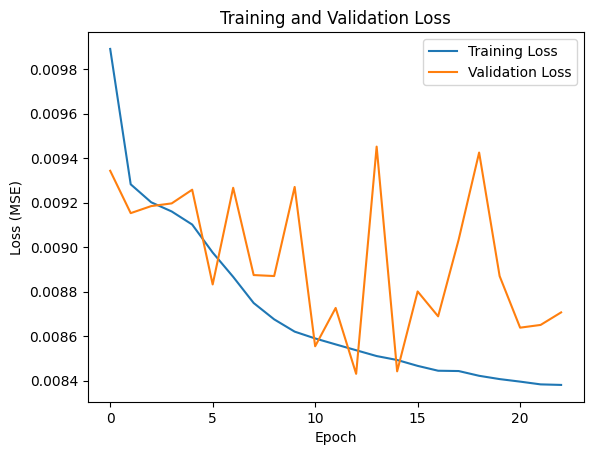

In [318]:
# Get training and validation losses from history
training_loss = history_data_rcp_2_6_prunay.history['loss']
validation_loss = history_data_rcp_2_6_prunay.history['val_loss']

# Plot loss values over epochs
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [319]:
# Make predictions data test
y_pred_inv_test, y_val_inv_test = predict_and_inverse_transform(model_data_rcp_2_6_prunay, X_data_rcp_2_6_prunay_test, y_data_rcp_2_6_prunay_test, target_transformer_data_rcp_2_6_prunay)

533/533 [==============================] - 2s 2ms/step


In [320]:
# Eavluate Model data train 
evaluate_model(y_val_inv_test, y_pred_inv_test)

MAE: 4.0596
RMSE: 5.1189
R2 Score: 0.4799


{'MAE': 4.059581659546295,
 'RMSE': 5.118899932864983,
 'R2 Score': 0.4798915532680642}

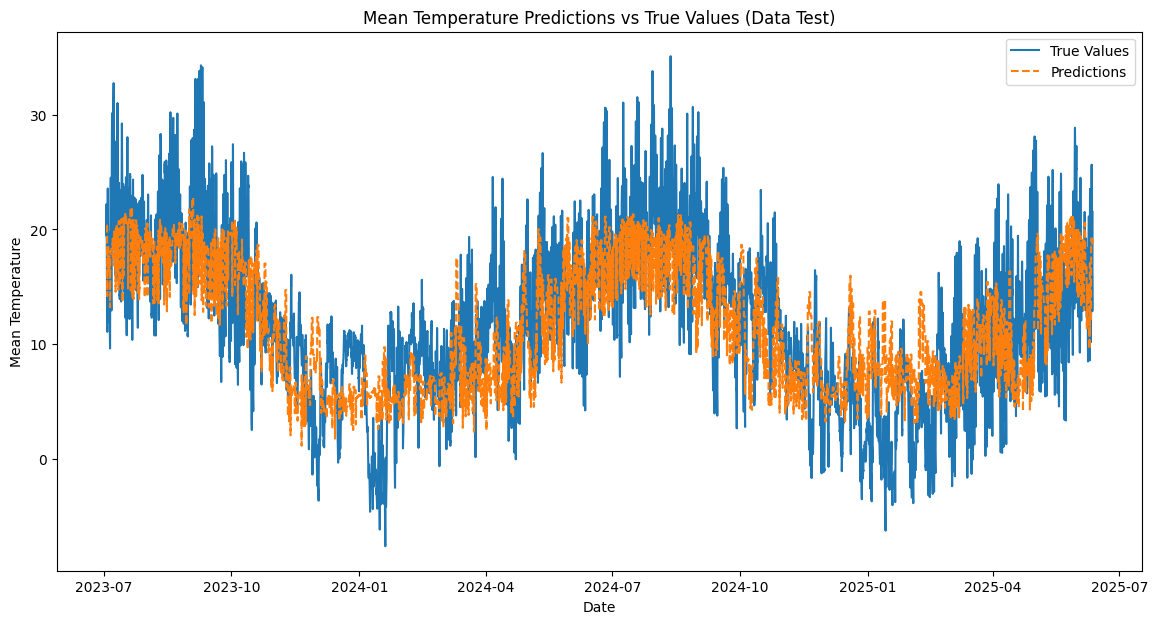

In [321]:
# Calcul des bornes d'index pour la partie test
start_test = len(y_data_rcp_2_6_prunay_train) + len(y_data_rcp_2_6_prunay_val) + sequence_length
end_test = start_test + len(y_data_rcp_2_6_prunay_test)

# Tracé
plt.figure(figsize=(14, 7))
plt.plot(data_rcp_2_6_prunay.index[start_test:end_test], y_val_inv_test, label='True Values')
plt.plot(data_rcp_2_6_prunay.index[start_test:end_test], y_pred_inv_test, label='Predictions', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.title('Mean Temperature Predictions vs True Values (Data Test)')
plt.legend()
plt.show()

In [322]:
y_pred_inv_test[0:100]

array([[20.330366 ],
       [20.330366 ],
       [20.330366 ],
       [20.330366 ],
       [20.330366 ],
       [20.330366 ],
       [20.330366 ],
       [20.330366 ],
       [20.330366 ],
       [20.330366 ],
       [20.330366 ],
       [20.330366 ],
       [20.330366 ],
       [20.330366 ],
       [20.330366 ],
       [20.142658 ],
       [15.826537 ],
       [14.182978 ],
       [14.269537 ],
       [15.304215 ],
       [18.546427 ],
       [18.470093 ],
       [18.470093 ],
       [18.470093 ],
       [18.470093 ],
       [18.470093 ],
       [18.470093 ],
       [18.470093 ],
       [18.470093 ],
       [18.470093 ],
       [18.47009  ],
       [18.47009  ],
       [18.470093 ],
       [18.470093 ],
       [18.470093 ],
       [18.470093 ],
       [18.470093 ],
       [18.470093 ],
       [18.470093 ],
       [17.86685  ],
       [17.353107 ],
       [16.732603 ],
       [16.415361 ],
       [16.48156  ],
       [17.123034 ],
       [17.650408 ],
       [17.650408 ],
       [17.65

In [323]:
data_rcp_2_6

,rcp_RH,rcp_Temperature,date
Date,,,
2006-01-01,93.570384,-0.04,2006-01-01
2006-01-02,100.000000,2.12,2006-01-02
2006-01-03,100.000000,8.96,2006-01-03
2006-01-04,89.964387,12.68,2006-01-04
2006-01-05,95.756756,8.96,2006-01-05
...,...,...,...
2100-12-27,77.246344,2.63,2100-12-27
2100-12-28,85.489534,0.72,2100-12-28
2100-12-29,95.290971,-0.24,2100-12-29


In [324]:
data_prunay

,prunay_RH,prunay_Temperature,date
time,,,
2006-01-01 00:00:00,98.142507,3.33438,2006-01-01
2006-01-01 01:00:00,97.822016,3.46914,2006-01-01
2006-01-01 02:00:00,97.719006,3.53042,2006-01-01
2006-01-01 03:00:00,97.871491,3.18423,2006-01-01
2006-01-01 04:00:00,97.894295,3.40884,2006-01-01
...,...,...,...
2025-06-12 04:00:00,93.596486,12.86025,2025-06-12
2025-06-12 05:00:00,92.706792,14.57950,2025-06-12
2025-06-12 06:00:00,90.352953,17.18080,2025-06-12


In [325]:
data_prunay_hourly_temp_predict = data_prunay_hourly_temp_predict.resample('D').agg(['min', 'mean', 'max'])

In [326]:
data_prunay_hourly_temp_predict["Jour_annee"] = data_prunay_hourly_temp_predict.index.dayofyear
data_prunay_hourly_temp_predict["Mois"] = data_prunay_hourly_temp_predict.index.month

In [327]:
data_prunay_hourly_temp_predict

prunay_RH                       prunay_Temperature             \
                  min       mean        max                min       mean   
time                                                                        
2006-01-01  97.719006  98.540228  99.558847            3.18423   4.205977   
2006-01-02  95.566497  97.590548  98.859619            2.47964   3.846317   
2006-01-03  95.869643  97.849224  99.020398           -0.02183   2.389316   
2006-01-04  93.792126  96.990512  98.967520           -1.66660   0.774877   
2006-01-05  95.571935  96.744393  97.852618           -1.58530   0.249098   
...               ...        ...        ...                ...        ...   
2025-06-08  84.845924  92.351952  97.821317            9.92080  14.433693   
2025-06-09  83.797271  91.292072  98.112890            8.47622  15.025831   
2025-06-10  85.605170  92.672336  98.624016            8.55996  16.870916   
2025-06-11  83.383625  90.981678  99.456448           10.16738  18.749932   
2025-06-12  87.579572  91.493826  93.596486           12.86025  15.916297   

                     Jour_annee Mois  
                 max                  
time                                  
2006-01-01   5.66934          1    1  
2006-01-02   5.40590          2    1  
2006-01-03   3.76162          3    1  
2006-01-04   3.14492          4    1  
2006-01-05   1.40127          5    1  
...              ...        ...  ...  
2025-06-08  18.37540        159    6  
2025-06-09  21.13467        160    6  
2025-06-10  23.53164        161    6  
2025-06-11  25.65420        162    6  
2025-06-12  21.52896        163    6  

[7103 rows x 8 columns]

In [328]:
data_prunay_hourly_temp_predict[('prunay_Temperature',  'min')]

time
2006-01-01     3.18423
2006-01-02     2.47964
2006-01-03    -0.02183
2006-01-04    -1.66660
2006-01-05    -1.58530
                ...   
2025-06-08     9.92080
2025-06-09     8.47622
2025-06-10     8.55996
2025-06-11    10.16738
2025-06-12    12.86025
Freq: D, Name: (prunay_Temperature, min), Length: 7103, dtype: float64

In [329]:
y = data_prunay["prunay_Temperature"].resample('D').apply(extract_24h_values)

time
2025-06-12 00:00:00    15.65127
2025-06-12 01:00:00    14.96743
2025-06-12 02:00:00    14.01553
2025-06-12 03:00:00    13.20570
2025-06-12 04:00:00    12.86025
2025-06-12 05:00:00    14.57950
2025-06-12 06:00:00    17.18080
2025-06-12 07:00:00    19.25723
2025-06-12 08:00:00    21.52896
Name: 2025-06-12 00:00:00, dtype: float64


In [330]:
y.shape

(7103,)

In [331]:
data_prunay_hourly_temp_predict.shape

(7103, 8)

In [332]:
data_prunay_hourly_temp_predict["y"] = y

In [333]:
data_prunay_hourly_temp_predict

prunay_RH                       prunay_Temperature             \
                  min       mean        max                min       mean   
time                                                                        
2006-01-01  97.719006  98.540228  99.558847            3.18423   4.205977   
2006-01-02  95.566497  97.590548  98.859619            2.47964   3.846317   
2006-01-03  95.869643  97.849224  99.020398           -0.02183   2.389316   
2006-01-04  93.792126  96.990512  98.967520           -1.66660   0.774877   
2006-01-05  95.571935  96.744393  97.852618           -1.58530   0.249098   
...               ...        ...        ...                ...        ...   
2025-06-08  84.845924  92.351952  97.821317            9.92080  14.433693   
2025-06-09  83.797271  91.292072  98.112890            8.47622  15.025831   
2025-06-10  85.605170  92.672336  98.624016            8.55996  16.870916   
2025-06-11  83.383625  90.981678  99.456448           10.16738  18.749932   
2025-06-12  87.579572  91.493826  93.596486           12.86025  15.916297   

                     Jour_annee Mois  \
                 max                   
time                                   
2006-01-01   5.66934          1    1   
2006-01-02   5.40590          2    1   
2006-01-03   3.76162          3    1   
2006-01-04   3.14492          4    1   
2006-01-05   1.40127          5    1   
...              ...        ...  ...   
2025-06-08  18.37540        159    6   
2025-06-09  21.13467        160    6   
2025-06-10  23.53164        161    6   
2025-06-11  25.65420        162    6   
2025-06-12  21.52896        163    6   

                                                            y  
                                                               
time                                                           
2006-01-01  [3.33438000000001, 3.4691400000000385, 3.53042...  
2006-01-02  [3.5174800000000346, 3.6612800000000334, 3.796...  
2006-01-03  [3.7616200000000504, 3.631740000000036, 3.6534...  
2006-01-04  [0.10122000000001208, 0.6918000000000006, 0.18...  
2006-01-05  [-1.585299999999961, -1.4251499999999737, -1.0...  
...                                                       ...  
2025-06-08  [14.261130000000037, 13.876370000000009, 13.59...  
2025-06-09  [8.735250000000008, 8.476220000000012, 8.83656...  
2025-06-10  [10.039940000000001, 9.53018000000003, 9.23160...  
2025-06-11  [12.010640000000024, 11.265530000000012, 10.47...  
2025-06-12                                               None  

[7103 rows x 9 columns]

In [334]:
y

time
2006-01-01    [3.33438000000001, 3.4691400000000385, 3.53042...
2006-01-02    [3.5174800000000346, 3.6612800000000334, 3.796...
2006-01-03    [3.7616200000000504, 3.631740000000036, 3.6534...
2006-01-04    [0.10122000000001208, 0.6918000000000006, 0.18...
2006-01-05    [-1.585299999999961, -1.4251499999999737, -1.0...
                                    ...                        
2025-06-08    [14.261130000000037, 13.876370000000009, 13.59...
2025-06-09    [8.735250000000008, 8.476220000000012, 8.83656...
2025-06-10    [10.039940000000001, 9.53018000000003, 9.23160...
2025-06-11    [12.010640000000024, 11.265530000000012, 10.47...
2025-06-12                                                 None
Freq: D, Name: prunay_Temperature, Length: 7103, dtype: object